# **Online Trainning  Docker CPU Power Estimating**

#### **I. Set-ups**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os

In [38]:
project_path = os.path.dirname(os.getcwd())
db_path = os.path.join(project_path, "jobs.db")

In [39]:
df = pd.read_sql_table(table_name="jobs", con=f"sqlite:///{db_path}")

In [40]:
df.head()

,job_id,file_name,num_util_files,submitted_at,started_at,finished_at,num_data_files,status,runtime,error,callback_URL,cpu_power
0,466514c4-5be0-4682-9210-0b303cf85323,466514c4-5be0-4682-9210-0b303cf85323.ipynb,3.0,2025-07-08 01:14:30,2025-07-08 01:15:00,2025-07-08 01:32:18,5.0,SUCCESS,1038.0,,,0.25
1,18f04cc6-988b-46b3-bc54-745c324adcf0,18f04cc6-988b-46b3-bc54-745c324adcf0.ipynb,0.0,2025-07-08 01:21:11,2025-07-08 01:21:41,2025-07-08 01:40:57,4.0,SUCCESS,1156.0,,,0.25
2,df462e15-00d6-4c19-93c7-bed44b0ef258,df462e15-00d6-4c19-93c7-bed44b0ef258.ipynb,2.0,2025-07-08 01:31:23,2025-07-08 01:31:53,2025-07-08 01:46:54,3.0,SUCCESS,901.0,,,0.25
3,d4608532-3ed3-4097-811a-d0a529a5f198,d4608532-3ed3-4097-811a-d0a529a5f198.ipynb,2.0,2025-07-08 01:42:03,2025-07-08 01:42:33,2025-07-08 01:54:02,0.0,SUCCESS,689.0,,,0.25
4,76a4a895-24e3-4a21-b351-b1dd0a01f306,76a4a895-24e3-4a21-b351-b1dd0a01f306.ipynb,3.0,2025-07-08 01:54:09,2025-07-08 01:54:39,2025-07-08 02:10:51,1.0,SUCCESS,972.0,,,0.25


In [41]:
df.tail()

,job_id,file_name,num_util_files,submitted_at,started_at,finished_at,num_data_files,status,runtime,error,callback_URL,cpu_power
331,a678edd3-bb4a-49c0-a967-6a380c6a12fb,test.ipynb,NaN,2025-07-10 06:31:39,None,2025-07-10 06:54:35,1.0,FAILURE,NaN,'numpy.float64' object is not callable,None,NaN
332,43d311f2-220a-4e67-a3f0-cd2fa850fe46,test.ipynb,NaN,2025-07-10 06:50:13,None,None,NaN,PENDING,NaN,None,None,NaN
333,c2706822-e953-4980-a249-9a3855e9bec6,test.ipynb,NaN,2025-07-10 07:21:35,None,2025-07-10 07:31:20,NaN,FAILURE,NaN,'numpy.float64' object is not callable,None,NaN
334,fa3cd067-e6d1-40fe-b0a1-9625c6c6e4ec,test.ipynb,NaN,2025-07-10 07:24:48,None,2025-07-10 07:34:04,NaN,FAILURE,NaN,'numpy.float64' object is not callable,None,NaN
335,ce846074-c960-43a9-bd1c-6742faf7b2b6,test.ipynb,NaN,2025-07-10 07:27:06,None,2025-07-10 07:36:24,NaN,FAILURE,NaN,'numpy.float64' object is not callable,None,NaN


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   job_id          336 non-null    object 
 1   file_name       336 non-null    object 
 2   num_util_files  331 non-null    float64
 3   submitted_at    336 non-null    object 
 4   started_at      331 non-null    object 
 5   finished_at     335 non-null    object 
 6   num_data_files  332 non-null    float64
 7   status          336 non-null    object 
 8   runtime         331 non-null    float64
 9   error           335 non-null    object 
 10  callback_URL    331 non-null    object 
 11  cpu_power       331 non-null    float64
dtypes: float64(4), object(8)
memory usage: 31.6+ KB


Problem:  
+ Total of 4 cores, 0.5 cores for OS and Gunicorn and Celery workers, 3.5 cores left for containers for running script.
+ Each containers may have x cpu core power (0.3, 0.5, 0.7, 0.75, 1)
+ At time t there might be n container running parallely.
+ Need to get x for time t: whenever a container created at time t it will be run with x cpu power.
+ There should not be lack of cpu or: 3.5/x <= n and x should be highest.  
  
Task:  
+ Predict demand n to find x.

#### **II. Analysis**

1. Get time gap

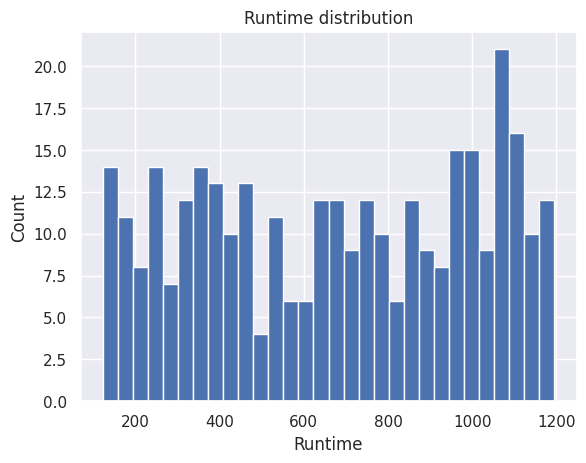

In [43]:
plt.hist(df["runtime"], bins=30)
plt.title("Runtime distribution")
plt.xlabel("Runtime")
plt.ylabel("Count")
plt.plot()
plt.show()

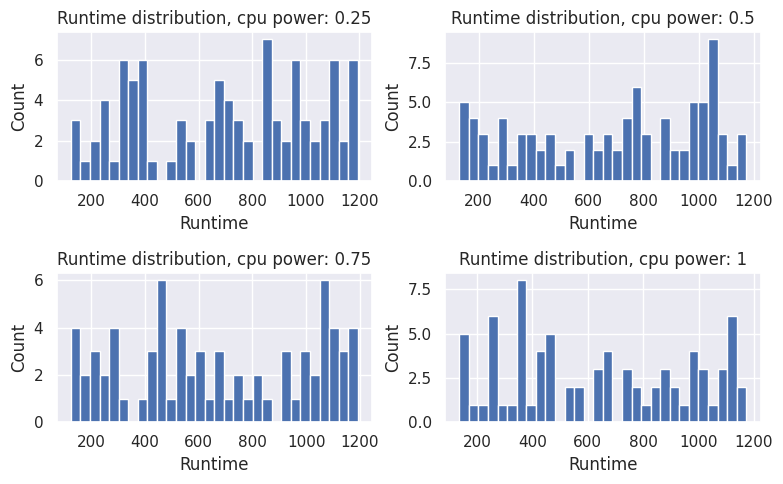

In [44]:
i = 1
cpu_list = [0.25, 0.5, 0.75, 1]

plt.figure(figsize=(8, 5))

for cpu in cpu_list:
  plt.subplot(2, 2, i)
  plt.hist(df[df["cpu_power"]==cpu]["runtime"], bins=30)
  plt.title(f"Runtime distribution, cpu power: {cpu}")
  plt.xlabel("Runtime")
  plt.ylabel("Count")
  i += 1
plt.tight_layout()
plt.show()

In [45]:
df["cpu_power"].unique()

array([0.25, 0.5 , 0.75, 1.  ,  nan])

In [46]:
df["status"].unique()

array(['SUCCESS', 'FAILURE', 'PENDING'], dtype=object)

In [47]:
max_time_gap = df["runtime"].max()/60
print(f"Max runtime: {max_time_gap} minutes")

Max runtime: 19.9 minutes


Not sufficient data, runtime does not follow any kind of distribution, choose 30 minutes as both arbitrary time gap and hopefully cover most runtime.

In [48]:
TIME_GAP = 30
NUM_TIME_STEP = int(np.floor(24*60/TIME_GAP))

In [49]:
demand = np.zeros((1, NUM_TIME_STEP))
demand.shape

(1, 48)

2. Bin time gap

In [50]:
df_timebin = df.copy()[["submitted_at", "started_at", "finished_at"]]

In [51]:
df_timebin['started_at'] = pd.to_datetime(df['started_at'])
df_timebin['time_bin_30min'] = (df_timebin['started_at'].dt.hour * NUM_TIME_STEP/24) + (df_timebin['started_at'].dt.minute // TIME_GAP) + 1

In [52]:
df_timebin['finished_at'] = pd.to_datetime(df['finished_at'])
df_timebin['time_bin_30min_fin'] = (df_timebin['finished_at'].dt.hour * NUM_TIME_STEP/24) + (df_timebin['finished_at'].dt.minute // TIME_GAP) + 1

In [53]:
df_timebin['day'] = df_timebin['started_at'].dt.day
N_DAYS = len(df_timebin['day'].unique())

In [54]:
df_timebin.drop(columns=["submitted_at", "started_at", "finished_at"], inplace=True)

In [55]:
df_timebin["gap"] = df_timebin["time_bin_30min_fin"] - df_timebin["time_bin_30min"]

In [56]:
df_timebin.head()

,time_bin_30min,time_bin_30min_fin,day,gap
0,3.0,4.0,8.0,1.0
1,3.0,4.0,8.0,1.0
2,4.0,4.0,8.0,0.0
3,4.0,4.0,8.0,0.0
4,4.0,5.0,8.0,1.0


In [57]:
df_timebin[df_timebin["gap"] > 0].shape[0] / 4 / 48 * 100

61.458333333333336

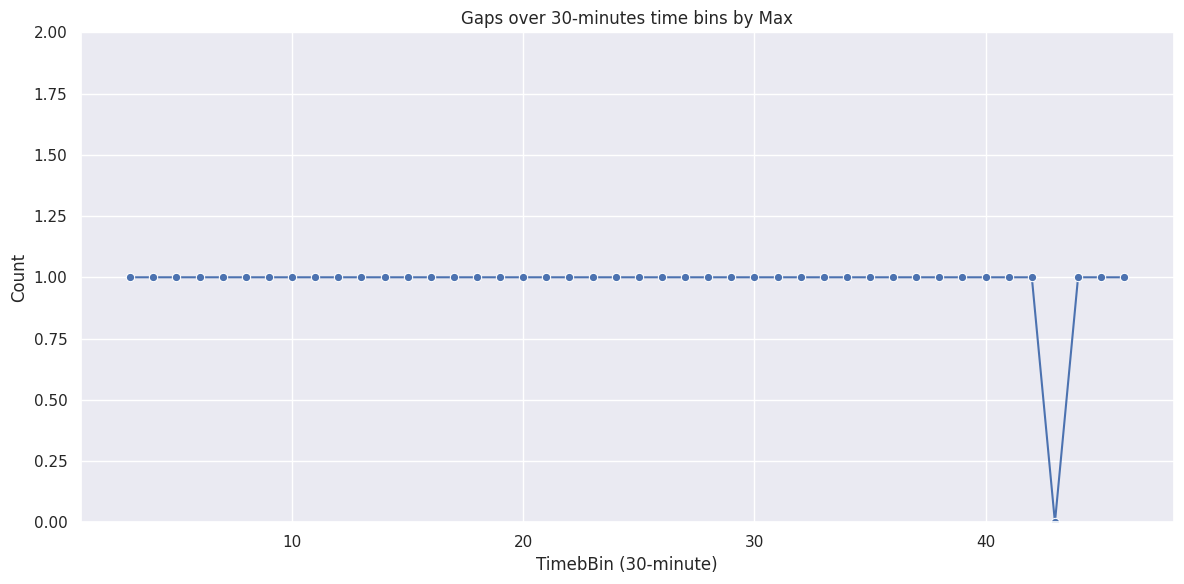

In [58]:
gap_per_time = df_timebin.drop(columns=["time_bin_30min_fin"]).groupby(["time_bin_30min"])["gap"].max().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='time_bin_30min', y='gap', data=gap_per_time, marker='o')
plt.title('Gaps over 30-minutes time bins by Max')
plt.xlabel('TimebBin (30-minute)')
plt.ylabel('Count')
plt.ylim([0, 2])
plt.tight_layout()
plt.show()

On average, 61.5 percent of job run cross from one time step to another and the max gap is only 1

At each time, the demand is the script started running at that time, plus the non finished script running from the previous time. Since mostly there is gap of 1, plus 1.

In [59]:
count_per_day = df_timebin.groupby(by=['day', 'time_bin_30min']).count()["time_bin_30min_fin"].rename("count").reset_index()
count_per_day["count"]
count_per_day

,day,time_bin_30min,count
0,8.0,3.0,2
1,8.0,4.0,3
2,8.0,5.0,3
3,8.0,6.0,3
4,8.0,7.0,3
...,...,...,...
159,11.0,42.0,1
160,11.0,43.0,2
161,11.0,44.0,2
162,11.0,45.0,1


In [60]:
full_time = count_per_day.copy()
full_time

,day,time_bin_30min,count
0,8.0,3.0,2
1,8.0,4.0,3
2,8.0,5.0,3
3,8.0,6.0,3
4,8.0,7.0,3
...,...,...,...
159,11.0,42.0,1
160,11.0,43.0,2
161,11.0,44.0,2
162,11.0,45.0,1


In [61]:
full_time["time_step"] = (full_time["day"] - full_time["day"].min()) * NUM_TIME_STEP + full_time["time_bin_30min"]
full_time["time_step"] = full_time["time_step"].astype(int)
full_time = full_time[["time_step", "count"]]
full_time

,time_step,count
0,3,2
1,4,3
2,5,3
3,6,3
4,7,3
...,...,...
159,186,1
160,187,2
161,188,2
162,189,1


In [62]:
demand_full = np.zeros((1, N_DAYS * NUM_TIME_STEP))

for t in full_time["time_step"].unique():
  demand_full[0, t-1] = full_time[full_time['time_step']==t]['count'].iloc[0]

demand_full_df = pd.DataFrame(data={
    "time_step": range(1, demand_full.shape[1]+1),
    "demand": demand_full[0, :]
})
demand_full_df.head()

,time_step,demand
0,1,0.0
1,2,0.0
2,3,2.0
3,4,3.0
4,5,3.0


In [63]:
demand_by_day = demand_full_df.copy()

demand_by_day['day'] = (demand_by_day['time_step'] // NUM_TIME_STEP).astype(int)
demand_by_day['time_step'] = demand_by_day['time_step'] - demand_by_day['day'] * NUM_TIME_STEP

demand_by_day.head()

,time_step,demand,day
0,1,0.0,0
1,2,0.0,0
2,3,2.0,0
3,4,3.0,0
4,5,3.0,0


3. Estimate

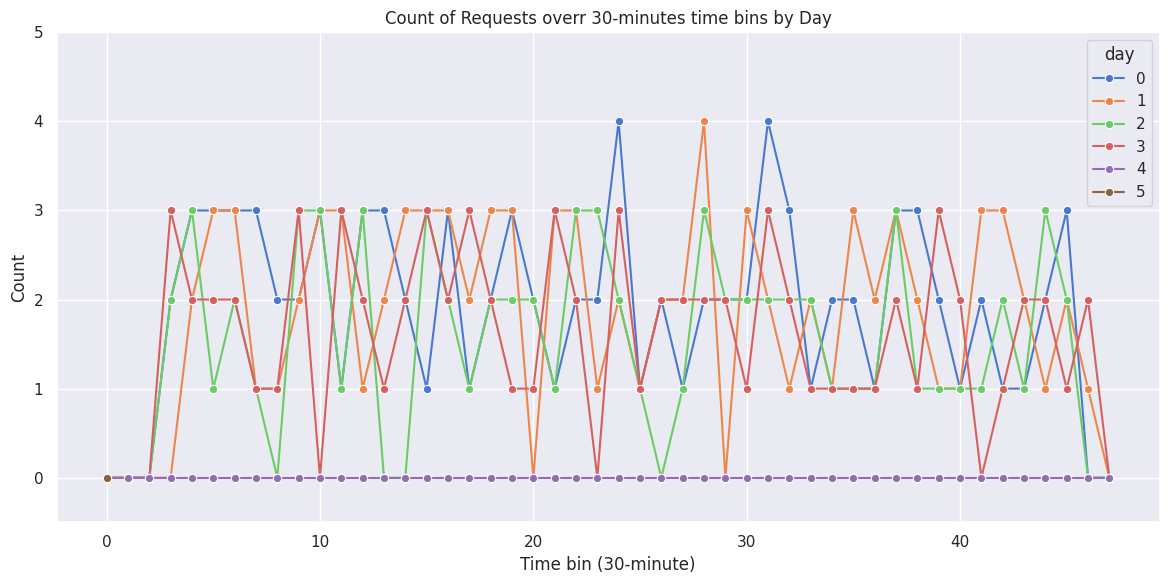

In [64]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='time_step', y='demand', hue='day', data=demand_by_day, marker='o', palette='muted')
plt.title('Count of Requests overr 30-minutes time bins by Day')
plt.xlabel('Time bin (30-minute)')
plt.ylabel('Count')
plt.tight_layout()
plt.ylim([-0.5, 5])
plt.show()

+ 4 days, certain patterns can be witness, some seemingly noise or completely random, not enough data to conclude.  
+ Day 0 and day 1 certainly have some peaks, note that these two days have fewer cpu power which means they can theoritically handle more request, yet no 'FAILURE' status is recored, so there might be problem with the recording system that cannot record failed task due to lack of cpu power, or it is just that day 0 and 1 have more requests.
+ There is likely none request at the start of the day, but during the day the later three day with higher cpu power show period with 0 request, this might might not be because of failure since at 1 power, there could be 3 jobs running.
+ Recheck the record system, until then use the max value as started demand hopfully cover all the request.


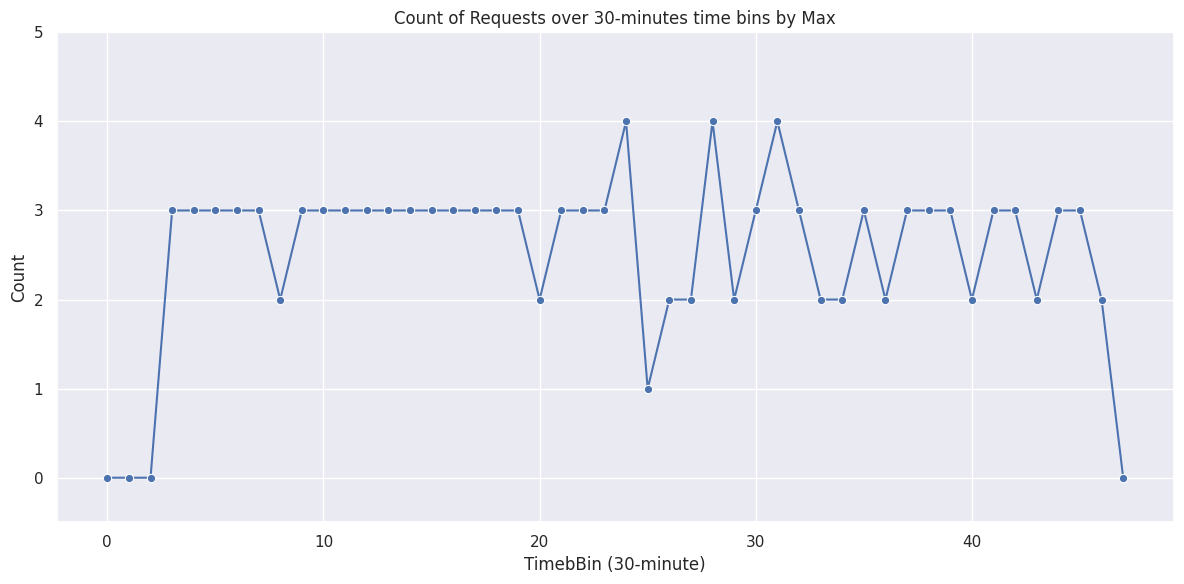

In [65]:
demand_by_day_max = demand_by_day.groupby("time_step").max()["demand"].reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='time_step', y='demand', data=demand_by_day_max, marker='o')
plt.title('Count of Requests over 30-minutes time bins by Max')
plt.xlabel('TimebBin (30-minute)')
plt.ylabel('Count')
plt.ylim([-0.5, 5])
plt.tight_layout()
plt.show()

In [66]:
for d in range(demand.shape[1]):
  try:
    demand[0, d] = demand_by_day_max[demand_by_day_max["time_step"]==(d+1)]["demand"].iloc[0] + 1
  except:
    demand[0, d] = 1
demand

array([[1., 1., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 3., 4., 4., 4., 5., 2., 3., 3., 5., 3., 4., 5., 4.,
        3., 3., 4., 3., 4., 4., 4., 3., 4., 4., 3., 4., 4., 3., 1., 1.]])

In [67]:
cpu_per_time = 3.5 / demand * 10
cpu_per_time = np.floor(cpu_per_time) / 10
cpu_per_time

array([[3.5, 3.5, 0.8, 0.8, 0.8, 0.8, 0.8, 1.1, 0.8, 0.8, 0.8, 0.8, 0.8,
        0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.1, 0.8, 0.8, 0.8, 0.7, 1.7, 1.1,
        1.1, 0.7, 1.1, 0.8, 0.7, 0.8, 1.1, 1.1, 0.8, 1.1, 0.8, 0.8, 0.8,
        1.1, 0.8, 0.8, 1.1, 0.8, 0.8, 1.1, 3.5, 3.5]])

4. Try exponential smoothing - Holt-Winters Additive Tripple Smoothing


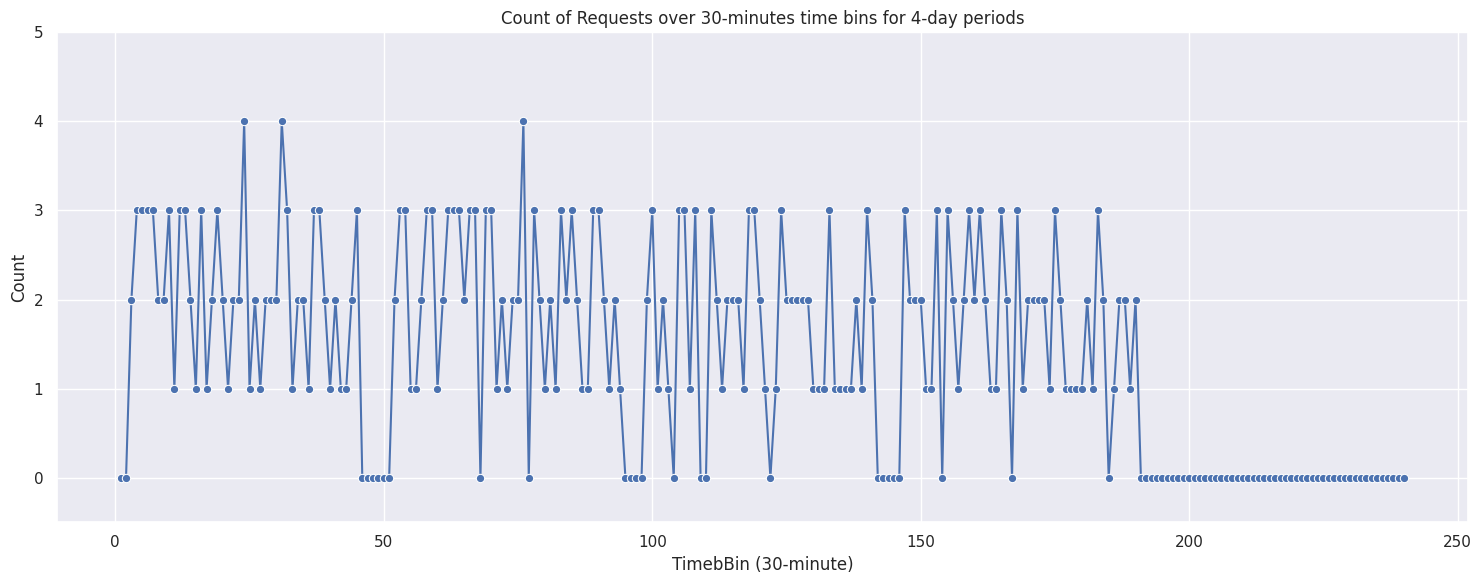

In [68]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='time_step', y='demand', data=demand_full_df, marker='o')
plt.title('Count of Requests over 30-minutes time bins for 4-day periods')
plt.xlabel('TimebBin (30-minute)')
plt.ylabel('Count')
plt.ylim([-0.5, 5])
plt.tight_layout()
plt.show()

In [69]:
def initial_seasonal_factors(s, d, slen, cols):

  # Season average
  for i in range(slen):
    s[i] = np.mean(d[i:cols:slen])

  s -= np.mean(s[:slen])

  return s

def holt_winter(d, alpha, beta, gamma, phi=0.9, extra_periods=1, slen=NUM_TIME_STEP):

  cols = len(d)
  d = np.append(d, [np.nan]*extra_periods)

  f,a,b,s = np.full((4, cols+extra_periods), np.nan)
  s = initial_seasonal_factors(s, d, slen, cols) # ini season

  a[0] = d[0] - s[0] # Ini level
  b[0] = (d[1]-s[1]) - (d[0]-s[0]) # Ini trend

  # Forecast for first season - no season factors forecast yet
  for t in range(1, slen):
    f[t] = a[t-1] + phi*b[t-1] + s[t]
    a[t] = alpha*(d[t]-s[t]) + (1-alpha)*(a[t-1]+phi*b[t-1])
    b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]

  # Forecast for t + 1
  for t in range(slen, cols):
    f[t] = a[t-1] + phi*b[t-1] + s[t-slen]
    a[t] = alpha*(d[t]-s[t-slen]) + (1-alpha)*(a[t-1]+phi*b[t-1])
    b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
    s[t] = gamma*(d[t]-a[t]) + (1-gamma)*s[t-slen]

  # Forecast for extra periods
  for t in range(cols, cols+extra_periods):
    f[t] = a[t-1] + phi*b[t-1] + s[t-slen]
    a[t] = f[t] - s[t-slen]
    b[t] = phi*b[t-1]
    s[t] = s[t-slen]

  df = pd.DataFrame.from_dict({
      "Demand":d,
      "Forecast":f,
      "Level":a,
      "Trend":b,
      "Season":s,
      "Error":d-f
  })

  return df


In [70]:
def mae(error, n):
  return 1/n * (error**2).sum()

In [71]:
# Grid search for alpha, beta, gamma
a_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
b_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
g_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

best_abg = []
loss_min = 100000

for a in a_list:
  for b in b_list:
    for g in g_list:
      result = holt_winter(d=demand_full[0,:], alpha=a, beta=b, gamma=g, extra_periods=24)
      loss = mae(result.iloc[0:demand_full.shape[1]]['Error'], demand_full.shape[1])
      print(f"Loss: {loss}")
      if loss < loss_min:
        best_abg = [a, b, g]
        loss_min = loss

best_abg

Loss: 0.6386173851275233
Loss: 0.6755845873930902
Loss: 0.7146977378290548
Loss: 0.7560943067853771
Loss: 0.8004261962286678
Loss: 0.8486852541023174
Loss: 0.9021038228004249
Loss: 0.9621303217555272
Loss: 1.0304798641401252
Loss: 1.1092599076820115
Loss: 0.6433179918004266
Loss: 0.6816091858389364
Loss: 0.7219949304844538
Loss: 0.7646548515614094
Loss: 0.8103300727133795
Loss: 0.8601436105551956
Loss: 0.915503551137262
Loss: 0.9780890077220805
Loss: 1.0499188598729832
Loss: 1.1335032738550737
Loss: 0.6528692603024492
Loss: 0.6926707733240095
Loss: 0.7344687110005187
Loss: 0.7784914022616772
Loss: 0.8256024746748216
Loss: 0.8771217519056503
Loss: 0.9347356605777222
Loss: 1.000497146530725
Loss: 1.076915100477521
Loss: 1.1671332930599605
Loss: 0.66304597350886
Loss: 0.7049567445233369
Loss: 0.7490718489742284
Loss: 0.7956727257575547
Loss: 0.8457483612506675
Loss: 0.9008249615492582
Loss: 0.9628925204756005
Loss: 1.0344282833580383
Loss: 1.118517106581713
Loss: 1.2190687129105322
Loss: 

[0.1, 0.1, 0.1]

0.1 each, the demand properties is reluctant to change and very close to history.

In [72]:
best_result = holt_winter(d=demand_full[0,:], alpha=best_abg[0], beta=best_abg[1], gamma=best_abg[2], extra_periods=NUM_TIME_STEP)

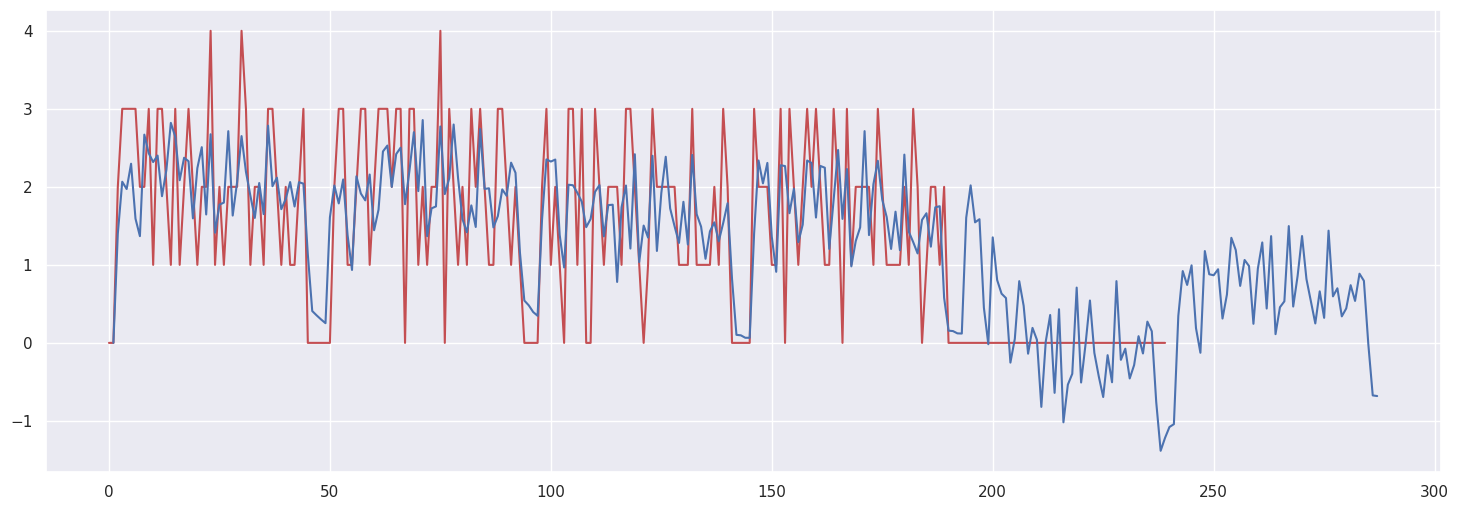

In [73]:
plt.figure(figsize=(18, 6))
plt.plot(best_result["Demand"], c='r')
plt.plot(best_result["Forecast"], c='b')
plt.show()

The model cannot capture suddent peak and since it also reluctant to change, it also cannot capture the sudden change  in demand as well. Seasonality can be seen.

In [74]:
best_result.tail()

,Demand,Forecast,Level,Trend,Season,Error
283,NaN,0.886589,0.652725,0.000330,0.233864,NaN
284,NaN,0.795563,0.653022,0.000297,0.142542,NaN
285,NaN,-0.017994,0.653289,0.000267,-0.671283,NaN
286,NaN,-0.673319,0.653529,0.000240,-1.326848,NaN
287,NaN,-0.681537,0.653745,0.000216,-1.335282,NaN


In [82]:
demand_for_the_day_after = np.asarray(best_result.iloc[demand_full.shape[1]:demand_full.shape[1]+NUM_TIME_STEP]["Forecast"])
demand_for_the_day_after = demand_for_the_day_after.clip(0)

In [83]:
demand_for_the_day_after.shape

(48,)

In [84]:
cpu_per_time_day_after = 3.5 / demand_for_the_day_after * 10
cpu_per_time_day_after = np.floor(cpu_per_time_day_after) / 10
cpu_per_time_day_after = cpu_per_time_day_after.reshape(1,-1)
cpu_per_time_day_after.tolist()[0]

/tmp/ipykernel_5377/376502866.py:1: RuntimeWarning: divide by zero encountered in divide
  cpu_per_time_day_after = 3.5 / demand_for_the_day_after * 10


[inf,
 inf,
 10.1,
 3.8,
 4.7,
 3.5,
 18.5,
 inf,
 2.9,
 3.9,
 4.0,
 3.7,
 11.2,
 5.6,
 2.5,
 2.9,
 4.7,
 3.2,
 3.5,
 14.3,
 3.6,
 2.7,
 7.9,
 2.5,
 31.3,
 7.6,
 6.5,
 2.3,
 7.5,
 4.0,
 2.5,
 4.2,
 6.5,
 14.0,
 5.3,
 10.9,
 2.4,
 5.8,
 5.0,
 10.3,
 7.9,
 4.7,
 6.5,
 3.9,
 4.3,
 inf,
 inf,
 inf]

#### **III. Save for system**

In [85]:
cpu_per_time_system = {
    "Max": cpu_per_time.tolist()[0],
    "H-W": cpu_per_time_day_after.tolist()[0],
    "num_time_step": NUM_TIME_STEP,
    "time_gap": TIME_GAP
}

In [86]:
import pickle as pkl
with open('cpu_per_time_system.pkl', 'wb') as f:
    pkl.dump(cpu_per_time_system, f)